<a href="https://colab.research.google.com/github/tsvlgd/micrograd/blob/main/notebooks/nn_autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3 * x ** 2 - 4 * x + 5

f(3.0)

20.0

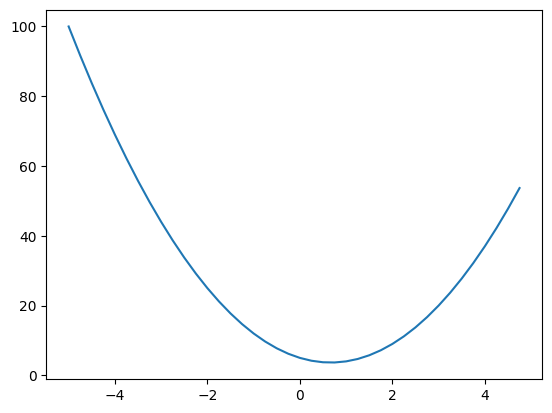

In [ ]:
# plot
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [ ]:
class Value:
  def __init__ (self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data)
    return out

  def __pow__(self, other):
    out = Value(self.data ** other.data) # raised by constant
    return out

a = Value (-2.0)
b = Value (3.0)
# prod = a * b
# prod
# a.__mul__(b)

In [ ]:
# step 1
#  go one step ahead keep track of previous values
class Value:

  def __init__ (self, data, _children=()):
    self.data = data
    self._prev = set(_children)

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self,other))
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self,other))
    return out

In [ ]:
a = Value (-2.0)
b = Value (3.0)
c = Value (1.0)
d = a*b + c
print(d)
print(d._prev)

Value(data=-5.0)
{Value(data=1.0), Value(data=-6.0)}


In [ ]:
# step 2: keep track of the operators what created these operands

class Value:

  def __init__ (self, data, _children=(), _op = '', label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self._backward = lambda: None
    self.label = label


  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self,other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self,other), '*')
    return out


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

In [ ]:
a = Value (-2.0)
b = Value (3.0)
c = Value (1.0)
d = a*b + c
print(d)
print(f"{d._prev}\nOperation= {d._op}")

Value(data=-5.0)
{Value(data=1.0), Value(data=-6.0)}
Operation= +


In [ ]:
!pip install graphviz

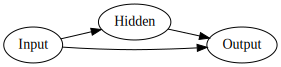

In [ ]:
from graphviz import Digraph

dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}, comment="Simple Graph") # LR = left -> right

dot.node("A", "Input")
dot.node("B", "Hidden")
dot.node("C", "Output")

dot.edge("A", "B")
dot.edge("B", "C")
dot.edge("A", "C")

dot

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

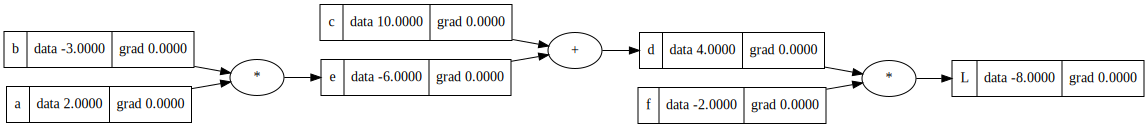

In [ ]:
draw_dot(L)

In [ ]:
# manual gradient calculation
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-3.9999999999995595


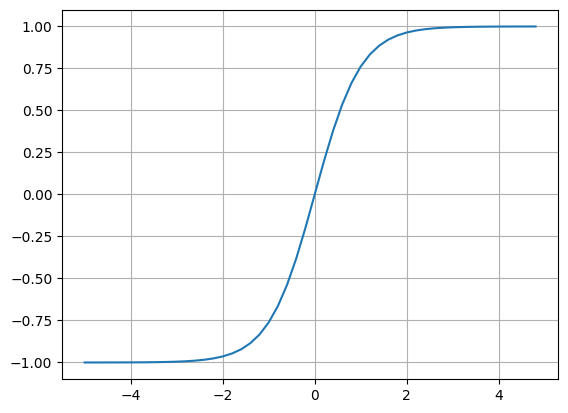

In [ ]:
# tanh
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

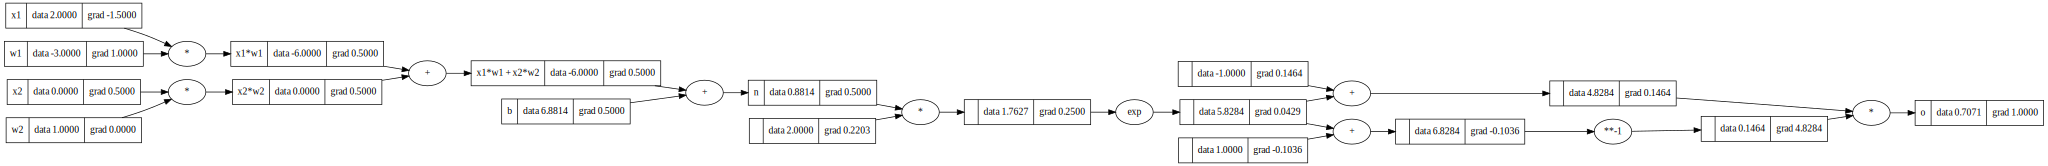

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = random.uniform(-1, 1)

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)) , self.b)
    out = act.tanh()
    return out

In [ ]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9985878737094969)

In [ ]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [ ]:
l1 = Layer(2,3)
# l1.neurons[0].w (for two inputs there are 3 neurons init in any layer)

In [ ]:
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts # [3, 4, 4, 1]
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.3774290517070533)

In [ ]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
out  = n(x)

In [ ]:
len(n.layers)

3

In [ ]:
n.layers

In [ ]:
sum([len(i.neurons) for i in n.layers])

9

In [ ]:
n.parameters()

[Value(data=-0.7302193550457734),
 Value(data=-0.5146651379744569),
 Value(data=0.4223441680744944),
 Value(data=0.6409562508561768),
 Value(data=0.8993068736885892),
 Value(data=0.23528746199044015),
 Value(data=0.6491726914912883),
 Value(data=0.5505776190288321),
 Value(data=-0.848688101273795),
 Value(data=-0.4127290590342112),
 Value(data=0.41158517923797544),
 Value(data=0.07142348119612563),
 Value(data=-0.08147406983389471),
 Value(data=0.7602777046325988),
 Value(data=-0.3493876307541284),
 Value(data=0.15616379755646914),
 Value(data=-0.3967036962997641),
 Value(data=-0.9763617631716333),
 Value(data=0.430955572245586),
 Value(data=0.8065832515190567),
 Value(data=0.8662677883586674),
 Value(data=0.5684298506688421),
 Value(data=-0.769978253906114),
 Value(data=-0.9122916579414349),
 Value(data=-0.8802902131049577),
 Value(data=-0.13643925910581411),
 Value(data=0.43872994550577493),
 Value(data=0.749479710634906),
 Value(data=-0.8159746502811012),
 Value(data=-0.634632779327

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
y_pred = [n(x) for x in xs]

In [ ]:
loss = sum((yout - ygt)** 2 for ygt, yout in zip(ys, y_pred))

In [ ]:
loss

Value(data=1.0236342091388746)

In [ ]:
n.layers[0].neurons[0].w[0].grad

0.0

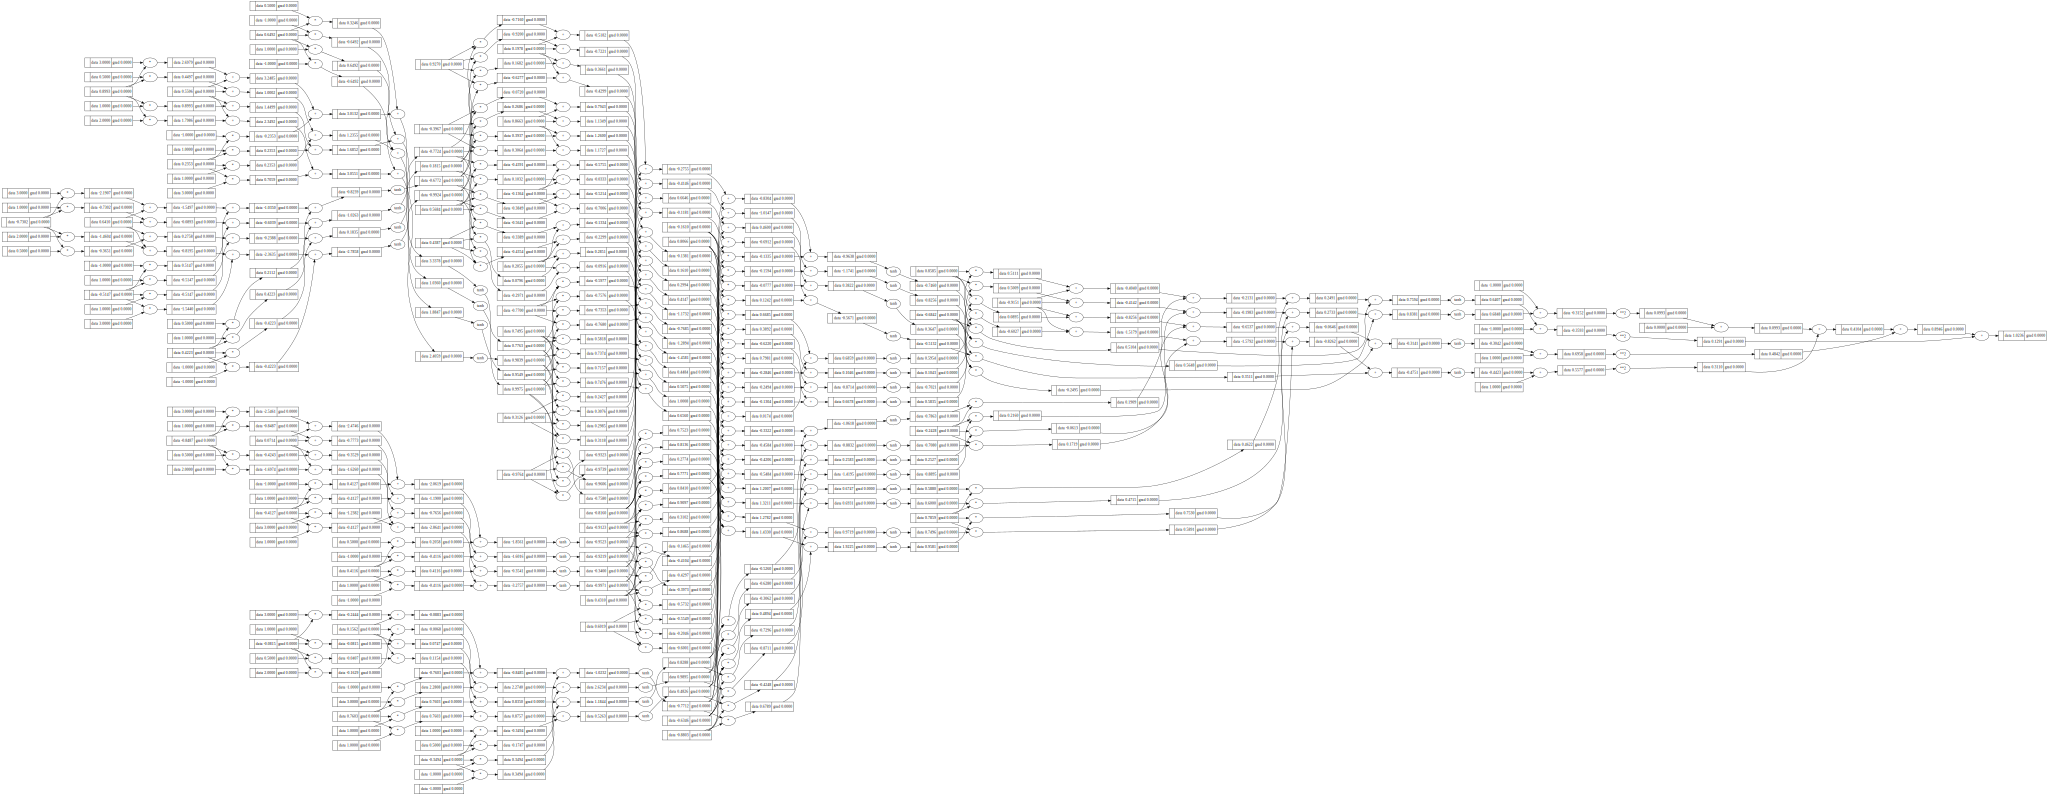

In [ ]:
draw_dot(loss)

In [ ]:
loss.backward()

In [ ]:
# more intuitevly
# it's influnce on the loss is negative, i.e : slightly increaseing this particular weight of this neuron of this weight will make the loss go down.

n.layers[0].neurons[0].w[0].grad

-1.512418371846609

### apply gradient descent

In [ ]:
for p in n.parameters():
  # p.data += ...
  p.data += 0.01 * p.grad

### understadnig zeroing grad before the loss.backward() and parameters.update()

In [ ]:
for k in range(100):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k+1, loss.data)

1 0.0005506578319571171
2 0.0005493630363007293
3 0.0005480742398316999
4 0.0005467914011469424
5 0.000545514479222713
6 0.000544243433410356
7 0.0005429782234319764
8 0.0005417188093762348
9 0.000540465151694219
10 0.0005392172111952886
11 0.0005379749490430748
12 0.0005367383267514743
13 0.0005355073061806999
14 0.000534281849533419
15 0.0005330619193508884
16 0.0005318474785092045
17 0.0005306384902155608
18 0.000529434918004566
19 0.0005282367257345903
20 0.0005270438775842397
21 0.0005258563380487755
22 0.0005246740719366057
23 0.0005234970443659057
24 0.0005223252207611637
25 0.0005211585668498591
26 0.000519997048659134
27 0.0005188406325125456
28 0.0005176892850268188
29 0.0005165429731086978
30 0.0005154016639517686
31 0.0005142653250333955
32 0.0005131339241116347
33 0.0005120074292222189
34 0.0005108858086755928
35 0.0005097690310539576
36 0.00050865706520837
37 0.0005075498802558795
38 0.0005064474455766703
39 0.000505349730811306
40 0.0005042567058579412
41 0.0005031683408

In [ ]:
y_pred

[Value(data=0.6848097741892369),
 Value(data=-0.44228407858577595),
 Value(data=-0.3041742650123338),
 Value(data=0.640738496047528)]